In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler


In [2]:
normal_data= pd.read_csv('BATADAL_dataset03.csv')
normal_data.DATETIME = pd.to_datetime(normal_data['DATETIME'])
normal_data.set_index('DATETIME', inplace = True)
attack_data = pd.read_csv('BATADAL_dataset04.csv', index_col='DATETIME')
normal_data.shape

(8761, 44)

In [3]:
#columns names contain blank spaces which have to be removed
strip = lambda container: map(lambda element: element.strip(), container)
attack_data.columns = strip(attack_data.columns.tolist())
normal_data.columns = strip(normal_data.columns.tolist())

In [4]:
#Remove labels
del normal_data['ATT_FLAG']

In [5]:
#Normalize trainset to make them zero-mean which is necessary for pca to work properly
normalize = StandardScaler()
normalized_train = normalize.fit_transform(normal_data)

In [6]:
attack_data.columns
attack_data.F_PU1
np.fft.fft(attack_data.F_PU1)

array([ 4.21204790e+05  +0.j        ,  7.41414345e+02-246.52816141j,
       -2.81432990e+02+863.09428883j, ...,  8.61755029e+01+220.64703659j,
       -2.81432990e+02-863.09428883j,  7.41414345e+02+246.52816141j])

In [7]:
##############
####PCA
#############

pca = PCA(n_components=normalized_train.shape[1])
normalized_train_transformed = pca.fit_transform(normalized_train)
normalized_train_transformed.shape

(8761, 43)

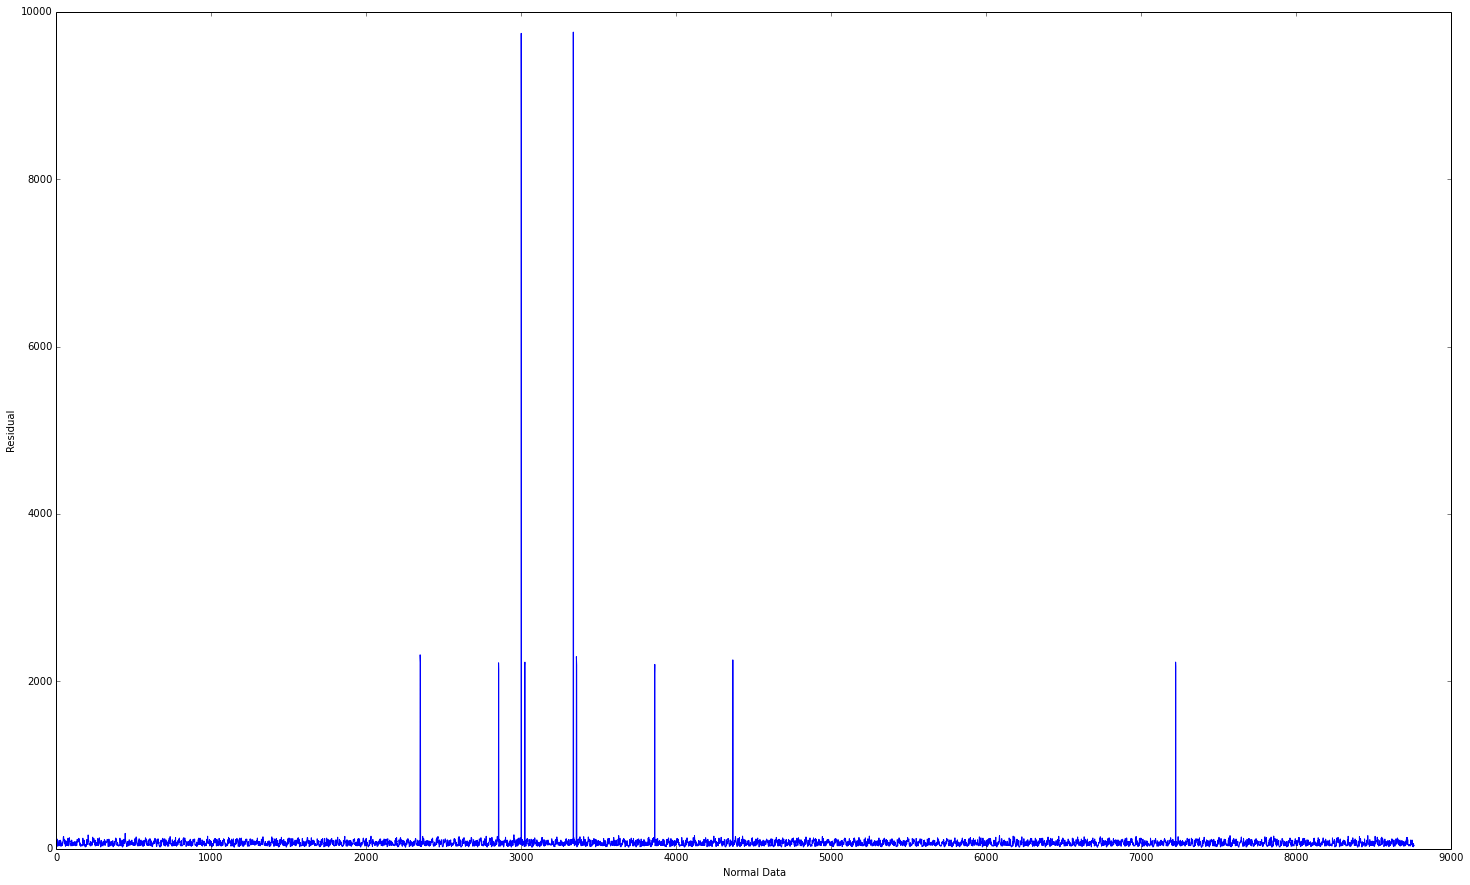

In [8]:
#investigate if there exist abnormalies in the normal data
normalized_train_reconstructed = pca.inverse_transform(normalized_train_transformed)
residual_pca1 = normalized_train_transformed - normalized_train_reconstructed
residual_pca2 = np.square(residual_pca1)
residual_pca = residual_pca2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[25,15])
plt.xlabel('Normal Data')
plt.ylabel('Residual')
plt.figure(figsize=[25,10])
ax.plot(residual_pca)

In [9]:
#from the figure above we see that there are some extremely large values in the normal dataset
#we have to remove the abnormalies found and then tune the parameters
max_index = np.argmax(residual_pca)
kati = np.where(residual_pca > 1000)
index = kati[0]
print('before', normal_data.shape)
for i in index:
    row = normal_data.iloc[[i]]
    normal_data = normal_data.drop(row.index)
print('after', normal_data.shape)

('before', (8761, 43))
('after', (8741, 43))


In [10]:
#normalize the cleaned data
normalize = StandardScaler()
normalized_train = normalize.fit_transform(normal_data)
#conduct PCA to the cleaned data in order to tune the parameters
pca = PCA(n_components=normalized_train.shape[1])
normalized_train_transformed = pca.fit_transform(normalized_train)
normalized_train_transformed.shape

(8741, 43)

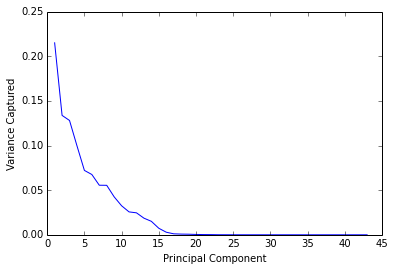

In [11]:
#Variance Captured plot
x_axis = np.arange(1, normalized_train_transformed.shape[1]+1, 1)
plt.xlabel('Principal Component')
plt.ylabel('Variance Captured')
plt.plot(x_axis, pca.explained_variance_ratio_)

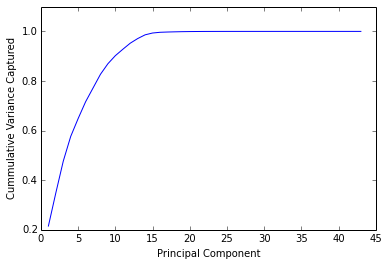

In [12]:
#Cummulative Variance Captured plot
cummulative_variance=pca.explained_variance_ratio_.cumsum()
x_axis = np.arange(1, normalized_train_transformed.shape[1]+1, 1)
plt.xlabel('Principal Component')
plt.ylabel('Cummulative Variance Captured')
plt.plot(x_axis, cummulative_variance)

In [13]:
# function of deciding the number of eigenvalue to use for PCA
def optimal_components(eigVals,percentage):  
    sortArray=np.sort(eigVals)   
    sortArray=sortArray[-1::-1]   
    arraySum=sum(sortArray)  
    tmpSum=0  
    num=0  
    for i in sortArray:  
        tmpSum+=i  
        num+=1  
        if tmpSum>=arraySum*percentage:  
            return num,sortArray

In [14]:
print(normal_data.shape)
#how many components explain the 99% of the variance
num,sortArray = optimal_components(pca.explained_variance_,0.99)
print 'Number of principle component:',num    # 6 principle component
#print 'array of eigenvalue:',sortArray        # variance

(8741, 43)
Number of principle component: 15


In [15]:
#calculate the threshold, according to the paper "Diagnosing Network-Wide Traffic Anomalies"
sorted_eigen = np.sort(pca.explained_variance_)
sorted_eigen = sorted_eigen[-1::-1]
print(sorted_eigen)
lambda1 = sorted_eigen
lambda2 = np.power(sorted_eigen,2)
lambda3 = np.power(sorted_eigen, 3)

fi1 = sum(lambda1[num:])
fi2 = sum(lambda2[num:])
fi3 = sum(lambda3[num:])
h0 = 1-2.0*fi1*fi3 /(3*(fi2**2))
Ca=0.01
threshold = fi1 * np.power(1.0 * Ca * np.sqrt(2* fi2 * (h0 ** 2)) / fi1
                           + 1 + 1.0 * fi2 * h0 * (h0-1) / (fi1 ** 2) , 1.0 / h0)
print fi1,fi2,fi3,h0,threshold

[7.74195370e+00 4.81487196e+00 4.61037933e+00 3.58967146e+00
 2.59651494e+00 2.43181865e+00 1.99912983e+00 1.99576337e+00
 1.53067360e+00 1.17063610e+00 9.23851979e-01 8.86088299e-01
 6.71248004e-01 5.43433620e-01 2.63472936e-01 1.04726410e-01
 3.93946033e-02 2.83588336e-02 2.38774095e-02 1.46522596e-02
 9.11329623e-03 7.42380611e-03 2.42575352e-03 1.91229908e-03
 1.01352827e-03 5.44020650e-04 3.06377909e-04 2.97101992e-04
 1.98634497e-04 1.94921584e-04 1.10334365e-04 6.05550147e-05
 1.04840328e-06 2.35380155e-08 8.49838003e-10 2.49974601e-10
 4.42902665e-32 4.42902665e-32 4.42902665e-32 4.42902665e-32
 4.42902665e-32 4.42902665e-32 4.42902665e-32]
0.2346112183482643 0.014257903431607986 0.0012504917495050178 0.03788494908343942 0.18397314271446413


In [16]:
#since we have tuned all the parametes we run now the pca
pca = PCA(n_components=num)
normalized_train_transformed = pca.fit_transform(normalized_train)
normalized_train_transformed.shape

(8741, 15)

In [17]:
normalized_train_reconstructed = pca.inverse_transform(normalized_train_transformed)


percentage of Abnormal data in training data: 48.0723029402


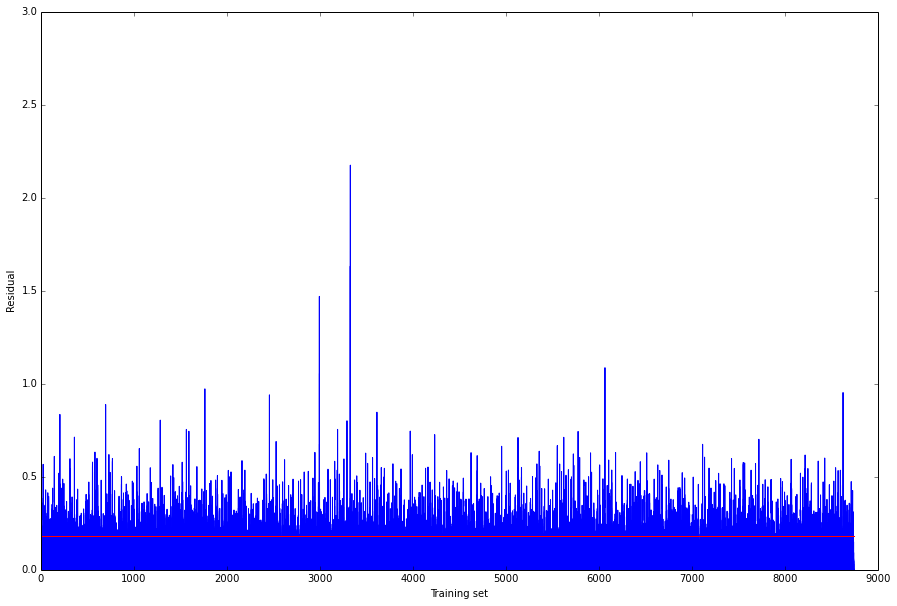

In [18]:
residual_pca1 = normalized_train - normalized_train_reconstructed
residual_pca2 = np.square(residual_pca1)
residual_pca = residual_pca2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[15,10])
plt.xlabel('Training set')
plt.ylabel('Residual')
plt.figure(figsize=[25,10])
ax.plot(residual_pca1,'b')
ax.plot([0,len(residual_pca)],[threshold,threshold],'r')
ax.set_ylim([0, 3])
print 'percentage of Abnormal data in training data:', 100.0 * sum(residual_pca>threshold)/len(residual_pca)

In [19]:
#testing phase with the dataset that contains attacks
label_test = attack_data['ATT_FLAG']
del attack_data['ATT_FLAG']
normalized_test = normalize.fit_transform(attack_data) # apply the same normalization with training data

In [20]:
#Find residuals
eigenvectors = pca.components_
P = np.transpose(eigenvectors[:-4])
P_T = np.transpose(P)
C = np.dot(P, P_T)
I = np.identity(attack_data.shape[1])

# y_residual corresponds to the projection of test data on anomalous subspace
y_residual = np.zeros((normalized_test.shape))

# Find projection of test data on anomalous subspace
for i in range(normalized_test.shape[0]):
    y = np.transpose(normalized_test[i])
    y_residual[i] = np.dot(I - C, y)  

In [21]:
#Calculate sqaured predicted error for each residual
spe = np.zeros((normalized_test.shape[0]))
predicted_labels = np.ones((normalized_test.shape[0]))
#even though we tried to tune the threshold with an function the results were not good
#thus we decided to find the threshold visually
#we investigated many thresholds and this one provides the best results
threshold = 90
for i in range(normalized_test.shape[0]):
    spe[i] = np.sum(np.square(np.subtract(y_residual[i], normalized_test[i])))     
    if(spe[i] > threshold):
        predicted_labels[i] = 1
    else:
        predicted_labels[i]=-999

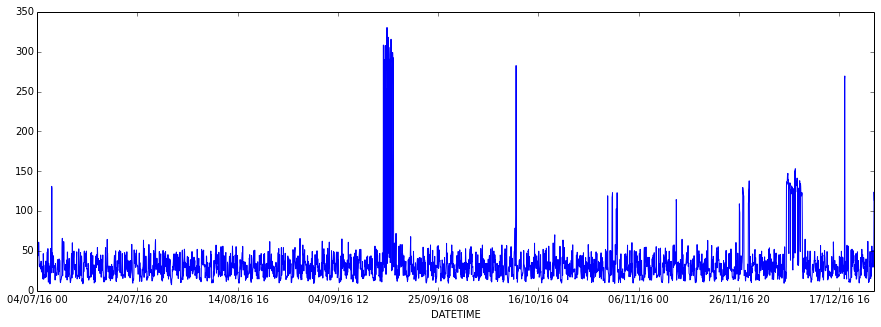

In [22]:
#Residuals Plot
attack_data = attack_data.assign(residual=spe)
attack_data['residual'].plot(figsize=(15,5))

In [23]:
#Finally we calculate the metrics using confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
tn, fp, fn, tp=confusion_matrix(label_test, predicted_labels).ravel()

In [24]:
Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
Precision=100.0*tp / (tp + fp)
Recall = 100.0*tp / (tp + fn)
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("TP:", tp)
print ("FP:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)

('TP:', 88)
('FP:', 38)
Accuracy: 95.95
Precision: 69.84
Recall: 40.18
F_score: 51.01


In [25]:
predicted_labels = pd.DataFrame(predicted_labels)
predicted_labels.to_csv('pca_predicted_labels.csv', index=False)